In [1]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 652 kB 37.4 MB/s 


In [ ]:
import trimesh

dir(trimesh)

In [3]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(42)

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
DATA_DIR = tf.keras.utils.get_file("modelnet.zip",
                                   "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
                                   extract=True)

DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 37s 0us/step


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

(2048, 3)


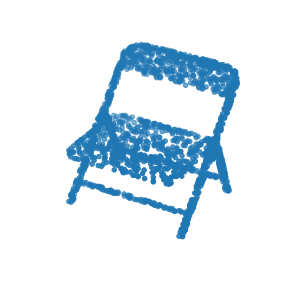

In [8]:
#3d data의 표면의 점들을 random sample로 반환
points = mesh.sample(2048)
print(points.shape)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2]) #산점도. 두 변수의 상관 관계를 직교 좌표계의 평면에 점을 표현
ax.set_axis_off() #축좌표 끄기
plt.show()

In [11]:
#dataset 나누기
#훈련시에 필요한 좌표와 레이블, 테스트에 필요한 좌표와 레이블, 그리고 sofa, desk 등등 10가지의 class로 된 class map으로 나눔
def parse_dataset(num_points=2048):

    train_points =[]
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return(
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map
    )

In [12]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: toilet
processing class: bed
processing class: night_stand
processing class: bathtub
processing class: monitor
processing class: desk
processing class: chair
processing class: table
processing class: dresser
processing class: sofa


In [13]:
CLASS_MAP

{0: 'toilet',
 1: 'bed',
 2: 'night_stand',
 3: 'bathtub',
 4: 'monitor',
 5: 'desk',
 6: 'chair',
 7: 'table',
 8: 'dresser',
 9: 'sofa'}

In [14]:
#균일분포에서 임의의 값들을 생성하여 원폰 이미지에 noise를 입힌 후 shuffle을 하여 augmentation 진행
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    
    return points, label

In [15]:
len(train_points)

3991

In [16]:
len(train_labels)

3991

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [18]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))